In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

klin =0

nband = 320

ng =12

ng_adju = (/ 0 , 0 /) 

ng_refs = (/ 3 , 3 , 6 /) 

nref =3

nv = 1000

option_compute_ktable =0

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 30 , 300 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =294

vstar = 20

data w_diffuse
     &     /1.8 , 1.8 , 1.8 , 1.8,
     &     1.8 , 1.8 , 1.8 , 1.8,
     &     1.8 , 1.8 , 1.8 , 1.8/

data wgt
     &     /0.6 , 0.6 , 0.6 , 0.6,
     &     0.6 , 0.6 , 0.6 , 0.75,
     &     0.75 , 0.75 , 0.75 , 0.75/

atmosphere_profiles/mls75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

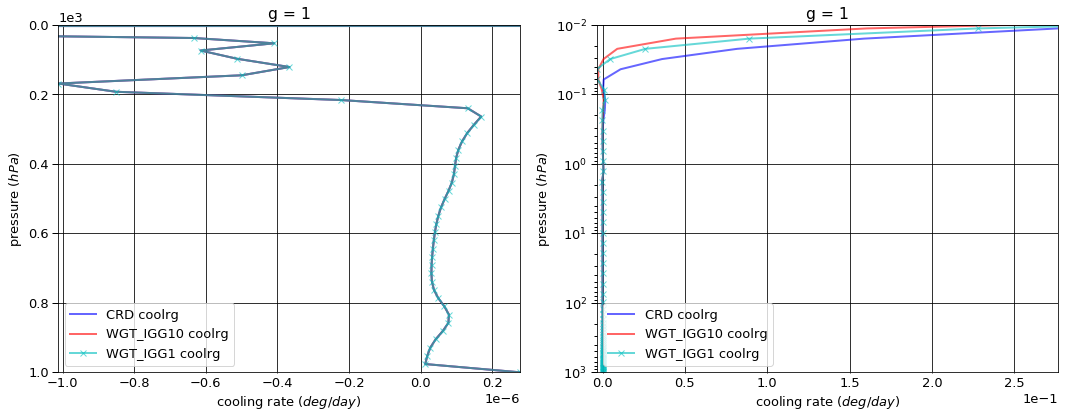

# Figure: cooling rate g-group 2

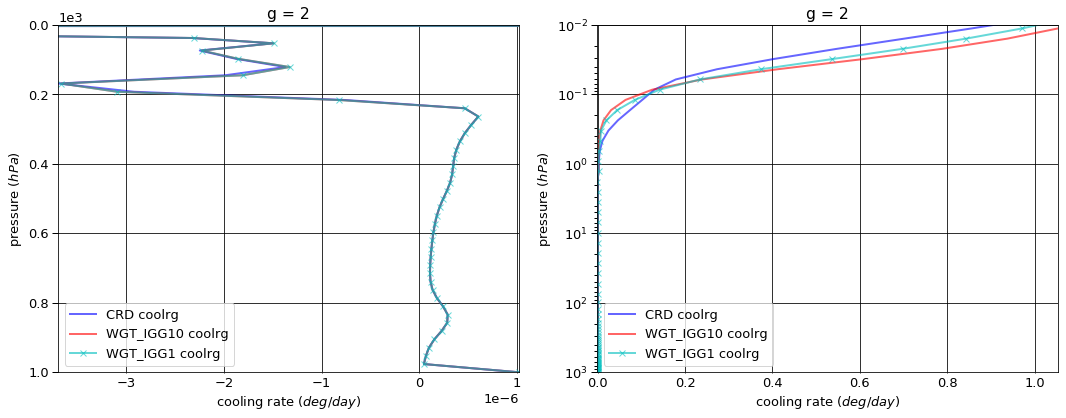

# Figure: cooling rate g-group 3

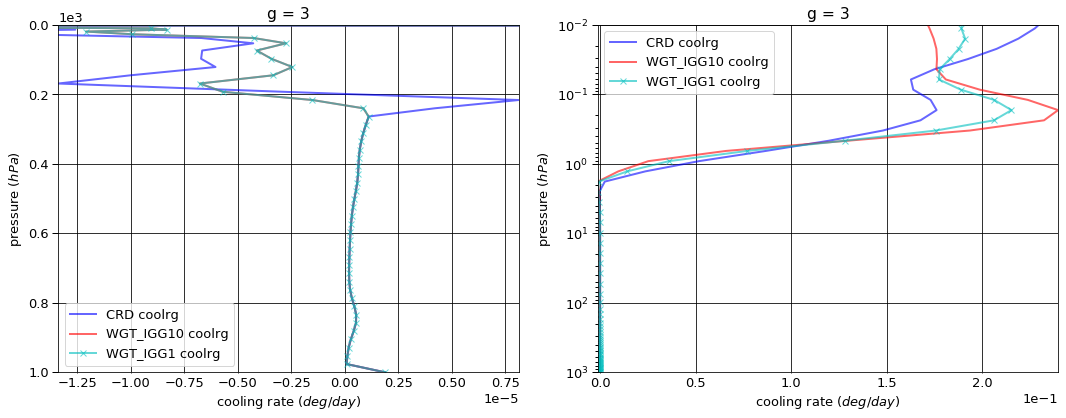

# Figure: cooling rate g-group 4

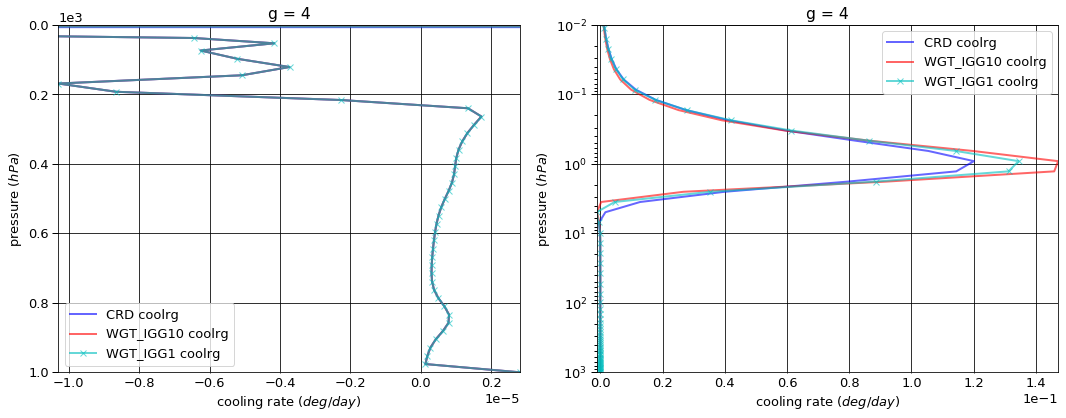

# Figure: cooling rate g-group 5

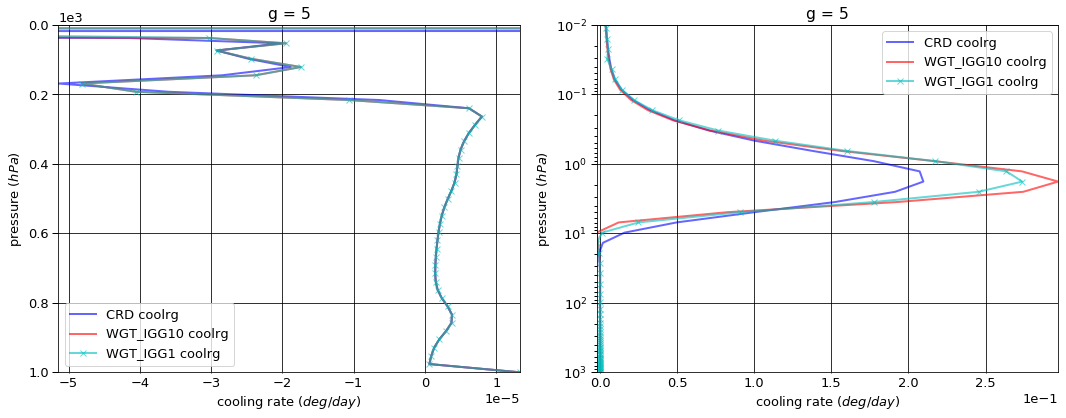

# Figure: cooling rate g-group 6

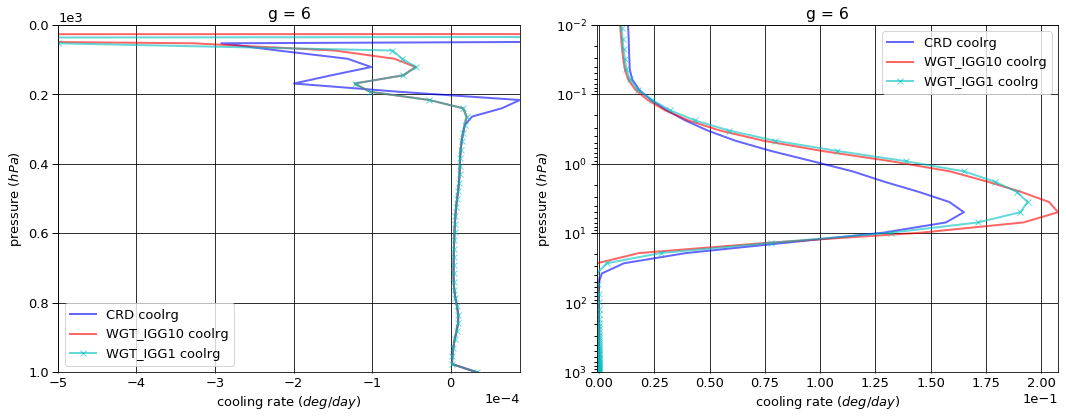

# Figure: cooling rate g-group 7

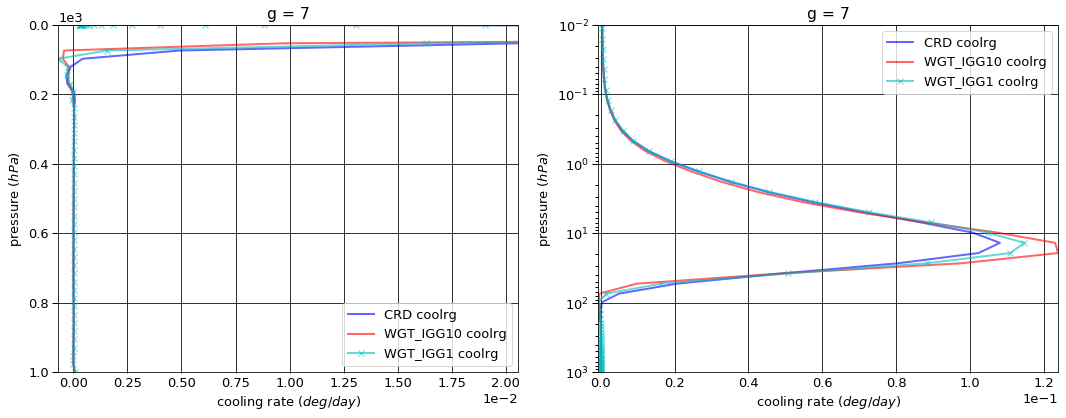

# Figure: cooling rate g-group 8

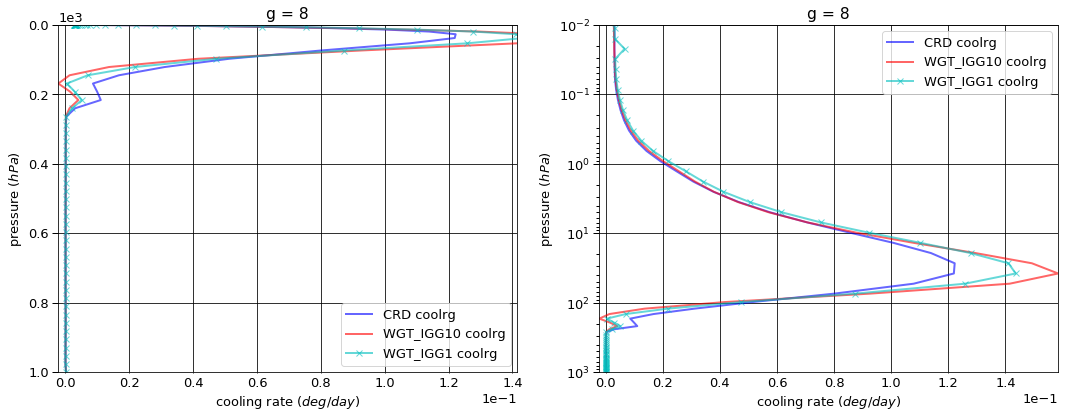

# Figure: cooling rate g-group 9

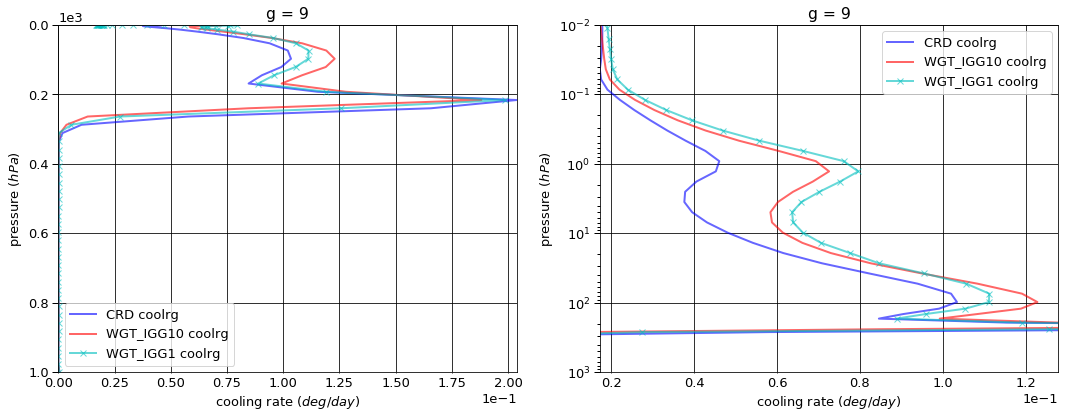

# Figure: cooling rate g-group 10

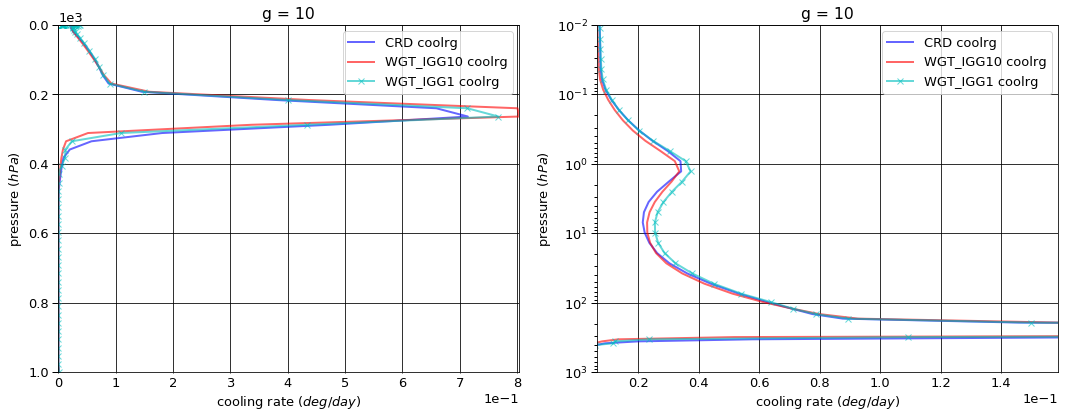

# Figure: cooling rate g-group 11

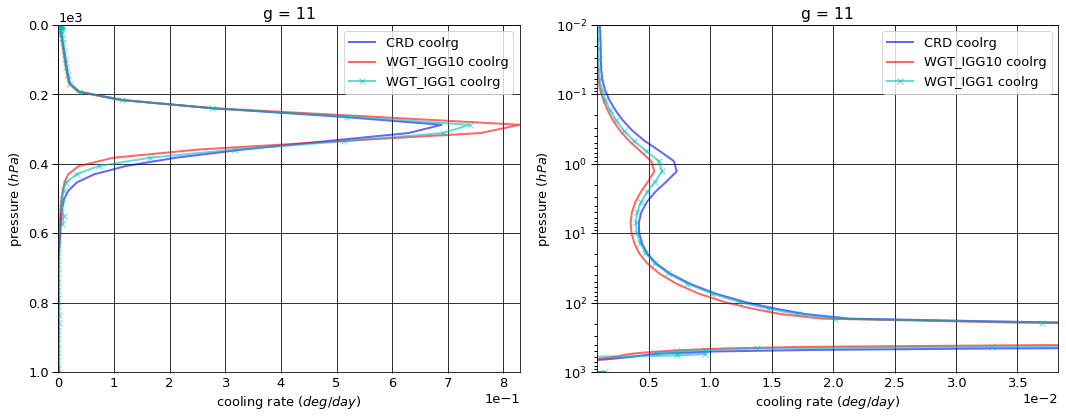

# Figure: cooling rate g-group 12

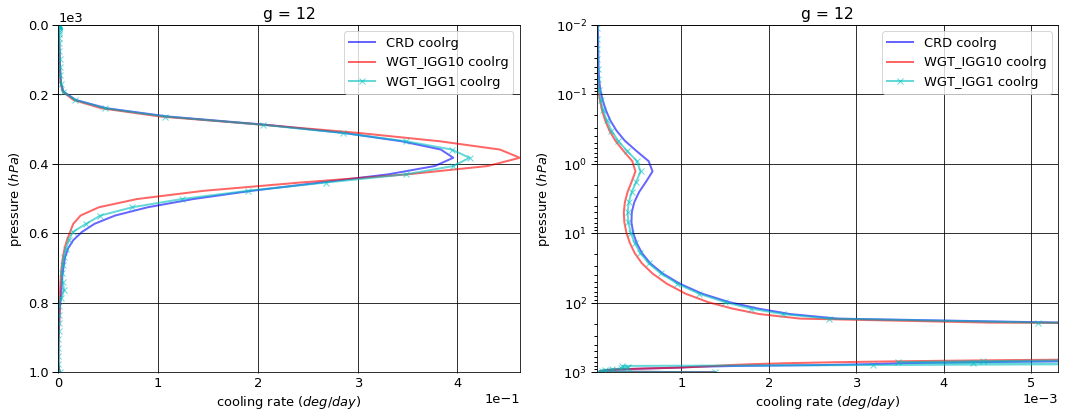

# Figure: cooling rate g-group total

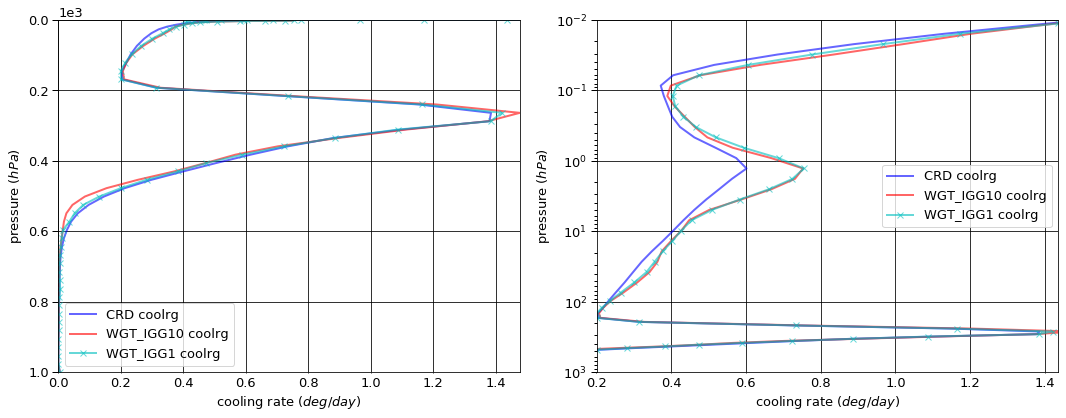

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg         fnetg
g  pressure level                                    
1  0.0      1      -0.001831   0.000000 -1.831251e-03
   1013.0   76     -0.003179   0.003178 -7.662036e-07
2  0.0      1      -0.006671   0.000000 -6.671062e-03
   1013.0   76     -0.011128   0.011125 -2.826396e-06
3  0.0      1      -0.015196   0.000000 -1.519632e-02
   1013.0   76     -0.020819   0.020814 -5.194229e-06
4  0.0      1      -0.027525   0.000000 -2.752511e-02
   1013.0   76     -0.032399   0.032391 -7.785377e-06
5  0.0      1      -0.119338   0.000000 -1.193377e-01
   1013.0   76     -0.149108   0.149072 -3.681344e-05
6  0.0      1      -0.274012   0.000000 -2.740121e-01
   1013.0   76     -0.379390   0.379297 -9.322619e-05
7  0.0      1      -0.450338   0.000000 -4.503377e-01
   1013.0   76     -0.686991   0.686823 -1.678838e-04
8  0.0      1      -1.364863   0.000000 -1.364863e+00
   1013.0   76     -2.214126   2.213586 -5.408576e-04
9  0.0      1      -3.456317   0.000000 -3.456317e+00
   1013.0   76     -5.628192   5.626814 -1.377513e-03
10 0.0      1      -8.730976   0.000000 -8.730976e+00
   1013.0   76    -13.505250  13.501908 -3.341547e-03
11 0.0      1     -10.276333   0.000000 -1.027633e+01
   1013.0   76    -15.101620  15.097691 -3.928715e-03
12 0.0      1      -9.509283   0.000000 -9.509283e+00
   1013.0   76    -13.341227  13.337388 -3.839095e-03


WGT_IGG10


flug       fldg         fnetg
g  pressure level                                    
1  0.0      1      -0.001822   0.000000 -1.822458e-03
   1013.0   76     -0.003179   0.003178 -7.662036e-07
2  0.0      1      -0.006443   0.000000 -6.443403e-03
   1013.0   76     -0.011128   0.011125 -2.826396e-06
3  0.0      1      -0.014793   0.000000 -1.479346e-02
   1013.0   76     -0.020819   0.020814 -5.194229e-06
4  0.0      1      -0.027834   0.000000 -2.783411e-02
   1013.0   76     -0.032399   0.032391 -7.785377e-06
5  0.0      1      -0.122764   0.000000 -1.227641e-01
   1013.0   76     -0.149108   0.149072 -3.681344e-05
6  0.0      1      -0.280692   0.000000 -2.806916e-01
   1013.0   76     -0.379390   0.379297 -9.322619e-05
7  0.0      1      -0.453798   0.000000 -4.537975e-01
   1013.0   76     -0.686991   0.686823 -1.678838e-04
8  0.0      1      -1.371734   0.000000 -1.371734e+00
   1013.0   76     -2.214126   2.213586 -5.408576e-04
9  0.0      1      -3.422727   0.000000 -3.422727e+00
   1013.0   76     -5.628192   5.626814 -1.377513e-03
10 0.0      1      -8.648741   0.000000 -8.648741e+00
   1013.0   76    -13.505250  13.501908 -3.341547e-03
11 0.0      1     -10.164461   0.000000 -1.016446e+01
   1013.0   76    -15.101620  15.097691 -3.928715e-03
12 0.0      1      -9.424695   0.000000 -9.424695e+00
   1013.0   76    -13.341227  13.337399 -3.827497e-03


WGT_IGG1


flug       fldg         fnetg
g  pressure level                                    
1  0.0      1      -0.001825   0.000000 -1.824879e-03
   1013.0   76     -0.003179   0.003178 -7.662036e-07
2  0.0      1      -0.006492   0.000000 -6.492111e-03
   1013.0   76     -0.011128   0.011125 -2.826396e-06
3  0.0      1      -0.014955   0.000000 -1.495512e-02
   1013.0   76     -0.020819   0.020814 -5.194229e-06
4  0.0      1      -0.027713   0.000000 -2.771281e-02
   1013.0   76     -0.032399   0.032391 -7.785377e-06
5  0.0      1      -0.121950   0.000000 -1.219505e-01
   1013.0   76     -0.149108   0.149072 -3.681344e-05
6  0.0      1      -0.279112   0.000000 -2.791120e-01
   1013.0   76     -0.379390   0.379297 -9.322619e-05
7  0.0      1      -0.452456   0.000000 -4.524559e-01
   1013.0   76     -0.686991   0.686823 -1.678838e-04
8  0.0      1      -1.370315   0.000000 -1.370315e+00
   1013.0   76     -2.214126   2.213586 -5.408576e-04
9  0.0      1      -3.441166   0.000000 -3.441166e+00
   1013.0   76     -5.628192   5.626814 -1.377513e-03
10 0.0      1      -8.686448   0.000000 -8.686448e+00
   1013.0   76    -13.505250  13.501908 -3.341547e-03
11 0.0      1     -10.213218   0.000000 -1.021322e+01
   1013.0   76    -15.101620  15.097691 -3.928715e-03
12 0.0      1      -9.482942   0.000000 -9.482942e+00
   1013.0   76    -13.341227  13.337399 -3.827497e-03


WGT_IGG10 - CRD


flug          fldg         fnetg
g  pressure level                                      
1  0.0      1      0.000009  0.000000e+00  8.792700e-06
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
2  0.0      1      0.000228  0.000000e+00  2.276592e-04
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
3  0.0      1      0.000403  0.000000e+00  4.028570e-04
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
4  0.0      1     -0.000309  0.000000e+00 -3.090010e-04
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
5  0.0      1     -0.003426  0.000000e+00 -3.426380e-03
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
6  0.0      1     -0.006679  0.000000e+00 -6.679480e-03
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
7  0.0      1     -0.003460  0.000000e+00 -3.459790e-03
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
8  0.0      1     -0.006871  0.000000e+00 -6.871400e-03
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
9  0.0      1      0.033590  0.000000e+00  3.359040e-02
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
10 0.0      1      0.082235  0.000000e+00  8.223530e-02
   1013.0   76     0.000000  0.000000e+00 -4.336809e-19
11 0.0      1      0.111872  0.000000e+00  1.118720e-01
   1013.0   76     0.000000 -1.776357e-15  0.000000e+00
12 0.0      1      0.084588  0.000000e+00  8.458820e-02
   1013.0   76     0.000000  1.100000e-05  1.159810e-05


WGT_IGG1 - CRD


flug          fldg         fnetg
g  pressure level                                      
1  0.0      1      0.000006  0.000000e+00  6.371500e-06
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
2  0.0      1      0.000179  0.000000e+00  1.789505e-04
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
3  0.0      1      0.000241  0.000000e+00  2.411970e-04
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
4  0.0      1     -0.000188  0.000000e+00 -1.876960e-04
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
5  0.0      1     -0.002613  0.000000e+00 -2.612750e-03
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
6  0.0      1     -0.005100  0.000000e+00 -5.099920e-03
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
7  0.0      1     -0.002118  0.000000e+00 -2.118180e-03
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
8  0.0      1     -0.005452  0.000000e+00 -5.452000e-03
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
9  0.0      1      0.015151  0.000000e+00  1.515120e-02
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
10 0.0      1      0.044528  0.000000e+00  4.452780e-02
   1013.0   76     0.000000  0.000000e+00 -4.336809e-19
11 0.0      1      0.063115  0.000000e+00  6.311500e-02
   1013.0   76     0.000000 -1.776357e-15  0.000000e+00
12 0.0      1      0.026341  0.000000e+00  2.634090e-02
   1013.0   76     0.000000  1.100000e-05  1.159810e-05

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      4.624137e+00
   1001.112500 75     2.771042e-07
2  0.000312    1      1.649035e+00
   1001.112500 75     1.022069e-06
3  0.000312    1      2.299625e-01
   1001.112500 75     1.878360e-06
4  0.000312    1      1.175310e-04
   1001.112500 75     2.815680e-06
5  0.000312    1      2.161069e-03
   1001.112500 75     1.331302e-05
6  0.000312    1      1.088342e-02
   1001.112500 75     3.371414e-05
7  0.000312    1      2.520366e-04
   1001.112500 75     6.071450e-05
8  0.000312    1      2.816524e-03
   1001.112500 75     1.955965e-04
9  0.000312    1      1.618383e-02
   1001.112500 75     4.981653e-04
10 0.000312    1      6.390181e-03
   1001.112500 75     1.208422e-03
11 0.000312    1      8.560223e-04
   1001.112500 75     1.420605e-03
12 0.000312    1      3.795263e-05
   1001.112500 75     1.388456e-03


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      4.240829e+00
   1001.112500 75     2.771042e-07
2  0.000312    1      1.267882e+00
   1001.112500 75     1.022069e-06
3  0.000312    1      1.470695e-01
   1001.112500 75     1.878360e-06
4  0.000312    1      1.221236e-04
   1001.112500 75     2.815680e-06
5  0.000312    1      2.078228e-03
   1001.112500 75     1.331302e-05
6  0.000312    1      7.624066e-03
   1001.112500 75     3.371414e-05
7  0.000312    1      2.646531e-04
   1001.112500 75     6.071450e-05
8  0.000312    1      2.569148e-03
   1001.112500 75     1.955965e-04
9  0.000312    1      1.549730e-02
   1001.112500 75     4.981653e-04
10 0.000312    1      5.724118e-03
   1001.112500 75     1.208422e-03
11 0.000312    1      6.341178e-04
   1001.112500 75     1.420605e-03
12 0.000312    1      2.533574e-05
   1001.112500 75     1.383709e-03


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      4.295414e+00
   1001.112500 75     2.771042e-07
2  0.000312    1      1.390965e+00
   1001.112500 75     1.022069e-06
3  0.000312    1      1.711110e-01
   1001.112500 75     1.878360e-06
4  0.000312    1      1.436112e-04
   1001.112500 75     2.815680e-06
5  0.000312    1      2.288615e-03
   1001.112500 75     1.331302e-05
6  0.000312    1      8.051578e-03
   1001.112500 75     3.371414e-05
7  0.000312    1      2.821614e-04
   1001.112500 75     6.071450e-05
8  0.000312    1      2.764781e-03
   1001.112500 75     1.955965e-04
9  0.000312    1      1.687321e-02
   1001.112500 75     4.981653e-04
10 0.000312    1      6.409161e-03
   1001.112500 75     1.208422e-03
11 0.000312    1      7.202348e-04
   1001.112500 75     1.420605e-03
12 0.000312    1      2.945727e-05
   1001.112500 75     1.383709e-03


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -3.833080e-01
   1001.112500 75     5.293956e-23
2  0.000312    1     -3.811526e-01
   1001.112500 75     0.000000e+00
3  0.000312    1     -8.289296e-02
   1001.112500 75    -2.117582e-22
4  0.000312    1      4.592660e-06
   1001.112500 75     0.000000e+00
5  0.000312    1     -8.284040e-05
   1001.112500 75     1.694066e-21
6  0.000312    1     -3.259356e-03
   1001.112500 75     0.000000e+00
7  0.000312    1      1.261651e-05
   1001.112500 75     0.000000e+00
8  0.000312    1     -2.473763e-04
   1001.112500 75    -2.710505e-20
9  0.000312    1     -6.865210e-04
   1001.112500 75     0.000000e+00
10 0.000312    1     -6.660628e-04
   1001.112500 75     0.000000e+00
11 0.000312    1     -2.219045e-04
   1001.112500 75     0.000000e+00
12 0.000312    1     -1.261689e-05
   1001.112500 75    -4.746400e-06


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -3.287238e-01
   1001.112500 75     5.293956e-23
2  0.000312    1     -2.580700e-01
   1001.112500 75     0.000000e+00
3  0.000312    1     -5.885151e-02
   1001.112500 75    -2.117582e-22
4  0.000312    1      2.608021e-05
   1001.112500 75     0.000000e+00
5  0.000312    1      1.275466e-04
   1001.112500 75     1.694066e-21
6  0.000312    1     -2.831844e-03
   1001.112500 75     0.000000e+00
7  0.000312    1      3.012481e-05
   1001.112500 75     0.000000e+00
8  0.000312    1     -5.174320e-05
   1001.112500 75    -2.710505e-20
9  0.000312    1      6.893810e-04
   1001.112500 75     0.000000e+00
10 0.000312    1      1.897960e-05
   1001.112500 75     0.000000e+00
11 0.000312    1     -1.357875e-04
   1001.112500 75     0.000000e+00
12 0.000312    1     -8.495359e-06
   1001.112500 75    -4.746400e-06

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.232683,0.000000,-34.232683
1013.0,76,-51.073430,51.060087,-0.013342



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-33.940504,0.000000,-33.940504
1013.0,76,-51.073430,51.060098,-0.013331



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.098592,0.000000,-34.098592
1013.0,76,-51.073430,51.060098,-0.013331



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.292179,0.000000,0.292179
1013.0,76,0.000000,0.000011,0.000012



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.134091,0.000000,0.134091
1013.0,76,0.000000,0.000011,0.000012


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,6.542833
1001.112500,75,0.004825



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,5.69032
1001.112500,75,0.00482



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,5.895052
1001.112500,75,0.004820



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.852513
1001.112500,75,-0.000005



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.647781
1001.112500,75,-0.000005


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000072,0.000064
2,0.000222,0.000220
3,0.000466,0.000413
4,0.000716,0.000650
5,0.003416,0.002969
6,0.008944,0.007564
7,0.015216,0.013716
8,0.054069,0.044218
9,0.134259,0.112332


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,5.008873e-16
2,7.670263e-17
3,1.174574e-17
4,2.908125e-17
5,4.811102e-18
6,7.959323e-19
7,1.130903e-18
8,1.928796e-19
9,3.289633e-20


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,5.008873e-16,NaN,0.000072,0.000064,0.000072,0.000064,1.0
2,7.670263e-17,0.153134,0.000222,0.000220,0.000294,0.000283,1.0
3,1.174574e-17,0.153134,0.000466,0.000413,0.000759,0.000697,1.0
4,2.908125e-17,2.475897,0.000716,0.000650,0.001475,0.001347,30.0
5,4.811102e-18,0.165437,0.003416,0.002969,0.004891,0.004315,30.0
6,7.959323e-19,0.165437,0.008944,0.007564,0.013834,0.011879,30.0
7,1.130903e-18,1.420853,0.015216,0.013716,0.029050,0.025595,300.0
8,1.928796e-19,0.170554,0.054069,0.044218,0.083119,0.069813,300.0
9,3.289633e-20,0.170554,0.134259,0.112332,0.217378,0.182145,300.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
